In [34]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as skio
import skimage
%matplotlib inline

In [53]:
data_info = pd.read_csv('../drivedata/driving_log.csv',
                        names=['img_center', 'img_left', 'img_right',
                               'steer_angle', 'throttle', 'brake', 'throttle'],
                        sep=', ')

/home/naoto/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [54]:
data_info[:3]

,img_center,img_left,img_right,steer_angle,throttle,brake,throttle
0,/home/naoto/Documents/udacity/simulator_projec...,/home/naoto/Documents/udacity/simulator_projec...,/home/naoto/Documents/udacity/simulator_projec...,0.0,0.000077,0,0.000077
1,/home/naoto/Documents/udacity/simulator_projec...,/home/naoto/Documents/udacity/simulator_projec...,/home/naoto/Documents/udacity/simulator_projec...,0.0,0.000079,0,0.000079
2,/home/naoto/Documents/udacity/simulator_projec...,/home/naoto/Documents/udacity/simulator_projec...,/home/naoto/Documents/udacity/simulator_projec...,0.0,0.000078,0,0.000078


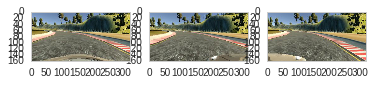

In [65]:
img = skio.imread(data_info['img_left'][0])
plt.subplot(1,3,2)
plt.imshow(img)

sns.set_style("whitegrid", {'axes.grid': False})
img = skio.imread(data_info['img_center'][0])
plt.subplot(1,3,1)
plt.imshow(img)

img = skio.imread(data_info['img_right'][0])
plt.subplot(1,3,3)
plt.imshow(img)
